# Scalable Batch Inference with Ray

<img src="../../_static/assets/Generic/ray_logo.png" width="20%" loading="lazy">

## About this notebook

### Is it right for you?

This module focuses on the batch inference task. It presents common design patterns for running batch inference and present few approaches how to implement batch inference with Ray depending on your needs. It is right for you if:

* you work with model (batch) inference problems and you observe performance bottlenecks
* you want to scale or increase throughput of your existing batch inference pipelines
* you wish to explore different architectures for batch inference with Ray Core and Ray AIR

### Prerequisites

For this notebook you should have:

* practical Python and machine learning experience
* familiarity with batch inference problem in ML
* familiarity with Ray and Ray AIR. Equivalent to completing these training modules:
  * [Overview of Ray](https://github.com/ray-project/ray-educational-materials/blob/main/Introductory_modules/Overview_of_Ray.ipynb)
  * [Introduction to Ray AIR](https://github.com/ray-project/ray-educational-materials/blob/main/Introductory_modules/Introduction_to_Ray_AIR.ipynb)
  * [Ray Core](https://github.com/ray-project/ray-educational-materials/tree/main/Ray_Core)

### Learning objectives

Upon completion of this notebook, you will know about:

* batch inference patterns
* how to implement scalable batch inference with Ray

### What will you do?

* learn about scaling inference with common design patterns
* explore different architectures for predicting on semantic segmentation tasks
* implement paralleized inference through hands-on coding exercises

## Part 1: Scalable batch inference design paterns with Ray

The end goal for machine learning models is to generate performant predictions over a set of unseen data. In this module, you will approach parallelizing batch inference on using Ray Core's API as well as the high-level abstractions available in Ray AI Runtime.

|<img src="../../_static/assets/Scaling_inference/ml_workflow.png" width="70%" loading="lazy">|
|:--|
|Example of a machine learning workflow.|

### Stateless inference - Ray Tasks

Loading complex models into memory can be expensive and sequential processing of requests limits speed. *Stateless inference* allows an ML system to handle high volume requests by:

1. exporting the model's mathematical core into a language agnostic format
2. restoring the architecture and weights of a trained model in a stateless function (i.e. Ray tasks)

A Ray task is *stateless* because its output (e.g. predictions) is determined purely by its inputs (e.g. the trained model). Performing online inference involves loading the model for every request and synchronously serving results.

|<img src="../../_static/assets/Scaling_inference/task_inference.png" width="70%" loading="lazy">|
|:--|
|Stateless inference using Ray Tasks.|

In the figure above, you perform batch inference by preprocessing your big dataset into batches that are assigned to workers via Ray tasks. Each task loads the trained model and outputs predictions on batches as they are assigned.

**Code Snippet**:

```python
object_refs = [task.remote(input) for _ in range(10)]
```

### Stateful inference with Ray Actors

When your deployed model takes too long to generate immediate results, online prediction may not be the right approach. In addition, some situations require predictions to be generated over large volumes of data such as curating personalized playlists. You can use *batch inference*, which is an asynchronous method of batching observations for prediction in advance to process a high volume of samples efficiently.

Setting up distributed batch inference with Ray involves:

1. creating a number of replicas of your model; in Ray, these replicas are represented as Actors (i.e., stateful processes) that can be assigned to GPUs and hold instantiated model objects

2. feeding data into these model replicas in parallel, and retrieve inference results

|<img src="../../_static/assets/Scaling_inference/actor_inference.png" width="70%" loading="lazy">|
|:--|
|Stateful inference using Ray Actors.|

Much like stateless inference using Ray tasks, stateful inference replaces Ray tasks with Ray actors and leverages Ray's object store to avoid loading the model for every batch.

**Code Snippet**:

```python
actors = [ActorCls.remote(input) for _ in range(10)]
```

### Stateful inference with Ray ActorsPool utility

Ray provides a convenient [ActorPool utility](https://docs.ray.io/en/latest/ray-core/package-ref.html#ray-util-actorpool) which wraps the above list of actors to avoid futures management.

|<img src="../../_static/assets/Scaling_inference/actor_pool.png" width="70%" loading="lazy">|
|:--|
|Using Actor Pools for Batch Inference.|

Building off of the stateful inference diagram, an Actor Pool wraps around the `n` actors so you do not have to manage idle actors and manually distribute workloads.

**Code Snippet**:

```python
from ray.util.actor_pool import ActorPool
actor_pool = ActorPool(actors)
```

### Batch inference with Ray AIR Datasets

Ray Datasets allows for parallel reading and preprocessing of source data along with autoscaling of the ActorPool. As a part of Ray AIR, you specify what you want done through a set of declarative key-value arguments rather than concerning yourself with how to instruct Ray to scale.

|<img src="../../_static/assets/Scaling_inference/ray_datasets.png" width="70%" loading="lazy">|
|:--|
|Ray Datasets replace the 'Batch preprocessing' stage.|

In Ray AIR, a trained model is loaded into a `Checkpoint` object (could be from training or tuning). An AIR `Predictor` loads model from the `Checkpoint` to perform inference. Then, using the preprocessed batches provided by Ray Datasets, you extract predictions off of the testing data.

**Code Snippet**:

```python
batches = data.map_batches(
              MyModel,
              num_gpus=1,
              batch_size-1024,
              compute=ray.data.ActorPoolStrategy(min_size=10, max_size=50)
          )
```

### Batch inference with high-level API - BatchPredictor

Ray AIR's [`BatchPredictor`](https://docs.ray.io/en/latest/ray-air/package-ref.html#batch-predictor) takes in a [`Checkpoint`](https://docs.ray.io/en/latest/ray-air/package-ref.html#checkpoint) which represents the saved model. This high-level abstraction offers simple and composable APIs that enable preprocessing data in batches with [BatchMapper](https://docs.ray.io/en/latest/ray-air/package-ref.html#generic-preprocessors) and instantiate a distributed predictor given checkpoint data.

|<img src="../../_static/assets/Scaling_inference/air_batchpredictor.png" width="70%" loading="lazy">|
|:--|
|Using Ray AIR's `BatchPredictor` for Batch Inference.|

Finally, you can use an AIR `BatchPredictor` that takes both the `Checkpoint` and `Predictor` to replace the process of manually performing inference on a large dataset.

**Code Snippet**:

```python
batch_predictor = BatchPredictor(
                      Checkpoint,
                      Predictor
                  )
```

## Part 2: Data and model used in this notebook - vision transformers for semantic segmentation

### SceneParse150 - MIT Scene Parsing Benchmark

Image segmentation takes a scene and classifies image objects [into semantic categories](https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit?usp=sharing) pixel-by-pixel. [MIT ADE20K Dataset](http://sceneparsing.csail.mit.edu/) (SceneParse150) provides the largest open source dataset for scene parsing, and in this notebook, you will be scaling inference on image regions depicted in these samples.

|<img src="../../_static/assets/Scaling_inference/scene.png" width="70%" loading="lazy">|
|:--|
|Test image on the left vs. predicted result on the right.[Source](https://github.com/CSAILVision/semantic-segmentation-pytorch) *Date accessed: November 10, 2022*|

Dataset Highlights:

* 20k annotated, scene-centric training images
* 2k validation images
* 150 total categories such as person, car, bed, sky, and more

### SegFormer - modern transformer for vision tasks

[SegFormer](https://arxiv.org/pdf/2105.15203.pdf) is a simple and powerful semantic segmentation method whose architecture consists of a hierarchical Transformer encoder and a lightweight All-MLP decoder. What sets SegFormer apart from previous approaches boils down to two key features:

1. a novel hierarchically structured Transformer encoder which does not depend on positional encoding, avoiding interpolation when test resolution differs from training
2. avoids complex decoders

With demonstrated success on benchmarks such as Cityscapes and [MIT ADE20K Dataset](http://sceneparsing.csail.mit.edu/), you will use a pretrained version to perform inference on test images from the SceneParse 150 dataset.

|<img src="../../_static/assets/Scaling_inference/segformer_architecture.png" width="70%" loading="lazy">|
|:--|
|Segformer architecture taken from [original paper](https://arxiv.org/pdf/2105.15203.pdf). *Date accessed: November 10, 2022*|


## Part 3: Sequential batch inference implementation

|<img src="../../_static/assets/Scaling_inference/single_seq_timeline.png" width="70%" loading="lazy">|
|:--|
|Sequential inference on the single worker. Performance is limited to the single machine performance.|

In [1]:
# imports
import torch
import numpy as np
from PIL import Image

/Users/emmy/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.manual_seed(201)

Setting the seed to a constant value ensures that multiple runs of the notebook produce the same results.

### Load pre-trained model from the HuggingFace Hub

In [3]:
from utils import get_labels
from transformers import SegformerForSemanticSegmentation

In [5]:
MODEL_NAME = "nvidia/segformer-b0-finetuned-ade-512-512"

There are five different segformers to choose from. The model chosen here is the smallest of the five. These models are pretrained and they are fine tuned on the MITADE20K dataset of 512x512 images. 

https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512

In [6]:
id2label, label2id = get_labels()
print(f"total labels: {len(id2label)}")
print(f"example lables: {list(id2label.values())[:5]}")

total labels: 150
example lables: ['wall', 'building', 'sky', 'floor', 'tree']


The function `get_labels` downloads from the `huggingface_hub` library the mappings `id2label` and `label2id` between the label IDs and the labels for the categories of objects in the images.

#### Load SegFormer

In [7]:
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_NAME, id2label=id2label, label2id=label2id
)
print(f"number of model parameters: {model.num_parameters()/(10**6):.2f} M")

number of model parameters: 3.75 M


The model loaded here is the smallest of the five segformers.

#### Create feature extractor

In [8]:
# "reduce_labels" is to drop background from loss compute: https://huggingface.co/docs/transformers/model_doc/segformer#segformer
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor.from_pretrained(
    MODEL_NAME, reduce_labels=True
)
feature_extractor

SegformerFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": true,
  "resample": 2,
  "size": 512
}

Every huggingface model has an associated feature extractor that preprocesses the input features. The flag `reduce_labels` removes the background from the loss computation.

### Prepare SceneParse150 dataset

#### Load dataset from the HuggingFace Hub

In [9]:
# Load dataset from Hugging Face
from datasets import load_dataset

DATASET_NAME = (
    "scene_parse_150"  # name of the dataset on the HuggingFace's datasets repository.
)

# split here only for fast-debug, remove before real use.
# ds = load_dataset(DATASET_NAME, split="train[:50]")  # for dry run only
dataset_dict = load_dataset(DATASET_NAME)
dataset_dict

Using the latest cached version of the module from /Users/emmy/.cache/huggingface/modules/datasets_modules/datasets/scene_parse_150/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75 (last modified on Tue Nov 22 21:55:59 2022) since it couldn't be found locally at scene_parse_150., or remotely on the Hugging Face Hub.
No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (/Users/emmy/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
100%|██████████| 3/3 [00:00<00:00, 261.19it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 20210
    })
    test: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 3352
    })
    validation: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 2000
    })
})

This can take some time, because you download data - over 20k images to the local machine or cluster.

The `load_dataset` utility loads the SceneParse150 dataset from Hugging Face's `datasets` library.

In [10]:
train_ds = dataset_dict["train"]
test_ds = dataset_dict["test"]

print(f"train_ds\n{train_ds}\n")
print(f"test_ds\n{test_ds}")

train_ds
Dataset({
    features: ['image', 'annotation', 'scene_category'],
    num_rows: 20210
})

test_ds
Dataset({
    features: ['image', 'annotation', 'scene_category'],
    num_rows: 3352
})


Store the training and testing data in `train_ds` and `test_ds` respectively.

#### Display example images

In [11]:
from utils import display_example_images

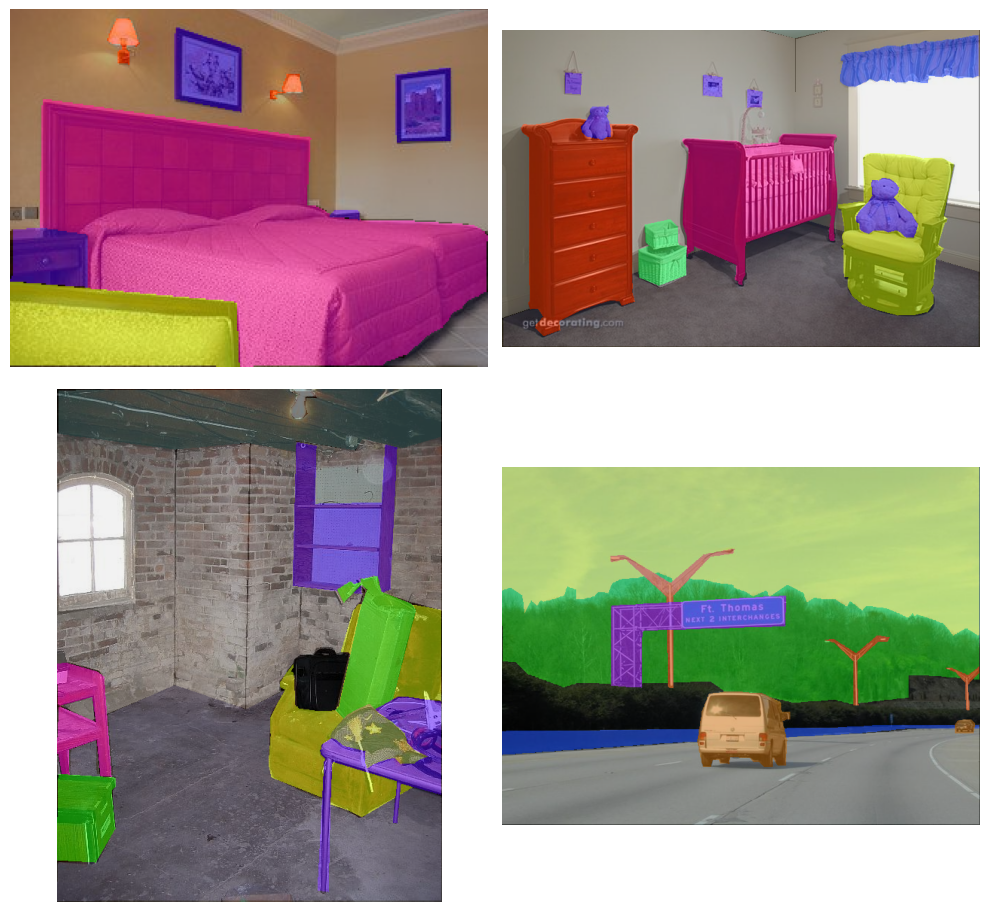

In [12]:
display_example_images(train_ds)

Each Hugging Face dataset comes with a `train_test_split` method that we're going to use next. We want 80% of the data to be training data, and 20% held back for testing.

To get a feel for what this dataset consists of, let's print the first of it. Since the train-test split we did is randomized, the resulting image will be different every time you load the dataset.

### Run inference on few images and visualize predictions

In [13]:
from utils import visualize_predictions

In [44]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def predict(model, image, device=dev, labels=None):
    if labels is not None:
        inputs = feature_extractor(
            images=image, segmentation_maps=labels, return_tensors="pt"
        )
        outputs = model(
            pixel_values=inputs.pixel_values.to(device), labels=inputs.labels.to(device)
        )
        loss = outputs.loss.cpu()
    else:
        inputs = feature_extractor(images=image, return_tensors="pt")
        outputs = model(pixel_values=inputs.pixel_values.to(device))
        loss = None

    upsampled_logits = torch.nn.functional.interpolate(
        outputs.logits.cpu(),
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    return upsampled_logits.argmax(dim=1)[0], loss

The `predict` function uses the input `model` to predict the label of each pixel in input image. The prediction takes the following steps:

1. The input image is converted using `feature_extractor` into three 512x512 images representing the three color chanels of the input image. This is independent of the original size of the input image.
2. The 512x512 images are then passed to the model, which then produces 150 128x128 images, one image for each available category. Each image is a mask representing the part of the image that belongs to that category.
3. In order to display the predicted regions on top of the original image, the 150 128x128 images are upsampled to the size of the original.
4. The 150 images are then collapsed into a single image using `argmax`, where each pixel has the label ID of the category predicted for that pixel.

#### Run inference on train set

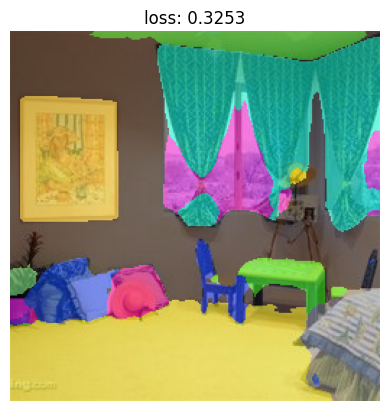

In [45]:
j = np.random.randint(train_ds.num_rows)

random_image = train_ds[j]["image"]
labels = train_ds[j]["annotation"]

segmentation, loss = predict(model=model, image=random_image, labels=labels)

visualize_predictions(image=random_image, predictions=segmentation, loss=loss)

Each time the cell is run, a different image from the training set is passed to `predict`, and the categories assigned to each pixel of the image are displayed with a different color.

#### Run inference on test set

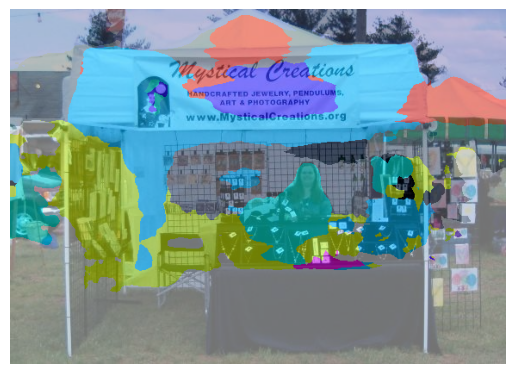

In [53]:
j = np.random.randint(test_ds.num_rows)

random_image = test_ds[j]["image"]
labels = test_ds[j]["annotation"]

segmentation, _ = predict(model=model, image=random_image)

visualize_predictions(image=random_image, predictions=segmentation)

Each time the cell is run, a different image from the testing set is passed to `predict`, and the categories assigned to each pixel of the image are displayed with a different color.

### Run sequential batch inference on data

#### Run inference on a single image

In [55]:
j = np.random.randint(train_ds.num_rows)

random_image = train_ds[j]["image"]
labels = train_ds[j]["annotation"]

Choose a random image from the training set to run inference on.

In [56]:
%%time

segmentation, loss = predict(model=model, image=random_image, labels=labels)

CPU times: user 1.44 s, sys: 677 ms, total: 2.11 s
Wall time: 491 ms


Time how long it takes to run `predict` on a single image.

##### Performance analysis

<div class="alert alert-info">
  <strong>Performance</strong> is as a wall time needed to run inference on batch. Measured in seconds.
</div>

|Compute       |Performance  |
|:-------------|:------------|
|M1 MacBook Pro|0.45s        |
|cluster 1 AWS |x.xxs        |
|cluster 2 AWS |x.xxs        |

Average time is approximately 0.45 seconds on the single image for SegFormer model with 3.7M parameters (b0 variant).


*Results are not representative and are meant to provide you with an intuitive understanding of the performance.*

#### Run batch inference on 10 images

In [57]:
from utils import get_image_ids

In [59]:
N_IMAGES = 10

images_ids = get_image_ids(dataset=train_ds, n_ids=N_IMAGES)
images_ids

[15605, 17372, 12070, 17185, 12082, 12763, 4222, 13191, 15187, 13589]

Get 10 random image IDs from the trianing dataset to run inference on.

In [60]:
%%time

predictions = []

for i in images_ids:
    image = train_ds[i]["image"]
    labels = train_ds[i]["annotation"]
    segmentation, loss = predict(model=model, image=image, labels=labels)
    predictions.append((segmentation, loss))

CPU times: user 12.3 s, sys: 7.58 s, total: 19.9 s
Wall time: 4.94 s


Time how long it takes to run `predict` in series on the 10 random images.

##### Performance analysis

Some experiments results:

|Compute       |Performance  |
|:-------------|:------------|
|M1 MacBook Pro|4.7s         |
|cluster 1 AWS |x.xxs        |
|cluster 2 AWS |x.xxs        |

Performance is a linear function of nuber of images in batch. Single image performance was 0.45s -> 10 images is 4.7s.

*Results are not representative and are meant to provide you with an intuitive understanding of the performance.*

### Summary: sequential batch inference implementation

|<img src="../../_static/assets/Scaling_inference/single_seq_timeline.png" width="70%" loading="lazy">|
|:--|
|Sequential inference on the single worker. Performance is limited to the single machine performance.|

|Compute       |1 image|10 images|100 images|
|:-------------|:------|:--------|:---------|
|M1 MacBook Pro|0.45s  |4.7s     |53s       |
|cluster 1 AWS |x.xxs  |.        |.         |
|cluster 2 AWS |x.xxs  |.        |.         |

#### Key Concepts

#### Key API Elements

## Part 4: Stateless inference - Ray Tasks

|<img src="../../_static/assets/Scaling_inference/task_inference.png" width="70%" loading="lazy">|
|:--|
|Stateless inference using Ray Tasks.|

### Initialize Ray runtime

In [61]:
import ray

if ray.is_initialized:
    ray.shutdown()

cluster_info = ray.init()
cluster_info.address_info

2022-11-23 21:05:32,830	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2022-11-23_21-05-30_735106_53838/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-11-23_21-05-30_735106_53838/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-11-23_21-05-30_735106_53838',
 'metrics_export_port': 56252,
 'gcs_address': '127.0.0.1:59820',
 'address': '127.0.0.1:59820',
 'dashboard_agent_listen_port': 52365,
 'node_id': '727e588d491312388dbf7430fc203f6ff00070701a6fb4264bc4fb21'}

### Put model in the object store

In [62]:
model_ref = ray.put(model)

Place the model in the object store to avoid copying every time the model is passed to a remote function or method.

### Implement remote function for inference

In [63]:
@ray.remote
def inference_task(model, image, labels):
    return predict(model=model, image=image, labels=labels)

The most naive version of parallelising prediction is to create Ray tasks that load the trained model internally when called. This way we can make the prediction task "stateless", but at the cost of incurring the overhead of loading the model every single time. This is akin to what serverless solutions like AWS Lambda would do, and this pattern could be worth it for tiny models, for which the application doesn't get bottle-necked by the model loading step.

### Run batch inference on 100 images and assess scalability

In [64]:
N_IMAGES = 100

images_ids = get_image_ids(dataset=train_ds, n_ids=N_IMAGES)

Get 100 random image IDs from the trianing dataset to run inference on.

In [66]:
%%time

prediction_refs = []
for i in images_ids:
    task_ref = inference_task.remote(
        model=model_ref, image=train_ds[i]["image"], labels=train_ds[i]["annotation"]
    )
    prediction_refs.append(task_ref)

predictions = ray.get(prediction_refs)

CPU times: user 1.01 s, sys: 312 ms, total: 1.33 s
Wall time: 13.2 s


Each call to the remote function `inference_task.remote` returns immediately. Ray then schedules each task to execute in parallel using the available resources. Calling `ray.get` waits for all the predictions to finish and returns the final results.

#### Performance analysis

<div class="alert alert-info">
  <strong>Performance</strong> is as a wall time needed to run inference on batch. Measured in seconds.
</div>

|Compute       |Performance  |
|:-------------|:------------|
|M1 MacBook Pro|13s          |
|cluster 1 AWS |x.xxs        |
|cluster 2 AWS |x.xxs        |

Distributed batch inference yields approximately 4x performance gain, when compared to the sequential implementation.

* Parallel: 13s.
* Sequential: 53s.

*Results are not representative and are meant to provide you with an intuitive understanding of the performance.*

### Summary: stateless inference - Ray Tasks

|<img src="../../_static/assets/Scaling_inference/task_inference.png" width="70%" loading="lazy">|
|:--|
|Stateless inference using Ray Tasks.|

|Compute       |10 image|100 images|1k images|10k images|
|:-------------|:-------|:---------|:--------|:---------|
|M1 MacBook Pro|1.3s    |13s       |125s     |n.a.      |
|cluster 1 AWS |x.xxs   |.         |.        |.         |
|cluster 2 AWS |x.xxs   |.         |.        |.         |

Average speed per prediction is 0.125s. That yields 4x performance speedup, when compared to the sequential approach, which is approximately 0.45s.

#### Key Concepts

#### Key API Elements


## Part 5: Stateful inference with Ray Actors

|<img src="../../_static/assets/Scaling_inference/actor_inference.png" width="70%" loading="lazy">|
|:--|
|Stateful batch inference using Ray Actors.|

### Implement remote class for inference

In [68]:
@ray.remote
class PredictionActor:
    def __init__(self, model):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def predict(self, image, labels=None):
        if labels is not None:
            inputs = feature_extractor(
                images=image, segmentation_maps=labels, return_tensors="pt"
            )
            outputs = self.model(
                pixel_values=inputs.pixel_values.to(self.device),
                labels=inputs.labels.to(self.device),
            )
            loss = outputs.loss.cpu()
        else:
            inputs = feature_extractor(images=image, return_tensors="pt")
            outputs = self.model(pixel_values=inputs.pixel_values.to(self.device))
            loss = None

        upsampled_logits = torch.nn.functional.interpolate(
            outputs.logits.cpu(),
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False,
        )

        return upsampled_logits.argmax(dim=1)[0], loss

Predict method is the same as in sequential implementation.

The benefit of using actors over tasks is that actors allow keeping track of state. In this particular case, each instance of `PredictionActor` will hold its own copy of the model, to avoid having to load the model every time a call to `predict` is made.

### Create list of Ray Actors

In [69]:
N_ACTORS = 7

idle_actors = []
for i in range(N_ACTORS):
    idle_actors.append(PredictionActor.remote(model=model_ref))

idle_actors

[Actor(PredictionActor, 7ba20acbec86e041b2200a4e01000000),
 Actor(PredictionActor, 8120aa184c9b034a0c81b89201000000),
 Actor(PredictionActor, 8c97cfcf5eb1358fd7caaf4301000000),
 Actor(PredictionActor, 292ddce168980b63dbd37c7801000000),
 Actor(PredictionActor, a54d0aa02ac63403e6fb028a01000000),
 Actor(PredictionActor, cc453d704d81a9a29e77eb9f01000000),
 Actor(PredictionActor, 9a2461cc0399e1fd8f6b423501000000)]

You named the list `idle_actors` as they are not doing anything yet.

### Run batch inference on 100 images with Ray Actors and assess scalability

In [73]:
def prediction_results_postprocessing(results, predictions):
    predictions.append(results)

The purpose of `prediction_results_postprocessing` is to abstract away the final processing step. In this demo, the postprocessing step is a very simple one, but in practice it will likely be much more complex.

In [74]:
N_IMAGES = 100
preds = []
future_to_actor_mapping = {}

images_ids = get_image_ids(dataset=train_ds, n_ids=N_IMAGES)
data = [(train_ds[i]["image"], train_ds[i]["annotation"]) for i in images_ids]

Get 100 random image IDs to run inference on. 

The variable `future_to_actor_mapping` will hold a mapping from futures to actors, to be able to determine which actors are idle by looking at the finished futures.

The `data` variable is a list of image-annotation pairs, where the annotation contains the correct labeling of all the segments in the image.

In [75]:
%%time

while data:
    if idle_actors:
        actor = idle_actors.pop()
        image, labels = data.pop()
        future = actor.predict.remote(image=image, labels=labels)
        future_to_actor_mapping[future] = actor
    else:
        [ready], _ = ray.wait(list(future_to_actor_mapping.keys()), num_returns=1)
        actor = future_to_actor_mapping.pop(ready)
        idle_actors.append(actor)
        prediction_results_postprocessing(ray.get(ready), preds)

# Process any leftover results at the end.
for future in future_to_actor_mapping.keys():
    prediction_results_postprocessing(ray.get(future), preds)

CPU times: user 310 ms, sys: 211 ms, total: 520 ms
Wall time: 15.1 s


The `while` loop goes over all the image-annotation pairs, and if there is an idle actor, that actor is assigned the next image-annotation pair to work on. If no actors are idle, the loop waits until an actor finishes, and the assigns the next image-annotation pair that actor. The `future_to_actor_mapping` is used to keep track of what each actor is working on, so that when a task is finished we know which actor finished it.

Finally, once all the data has been assigned, we wait for all remaining actors to finish their tasks.

In [76]:
preds[0]

(tensor([[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [15, 15, 15,  ..., 15, 15, 15],
         [15, 15, 15,  ..., 15, 15, 15],
         [15, 15, 15,  ..., 15, 15, 15]]),
 tensor(0.5937, requires_grad=True))

based on this: https://docs.ray.io/en/master/ray-core/patterns/limit-pending-tasks.html

ray.wait() -> https://docs.ray.io/en/latest/ray-core/package-ref.html#ray-wait

|<img src="../../_static/assets/Scaling_inference/seq_timeline.png" width="70%" loading="lazy">|
|:--|
|Timeline of sequential batch assignment spread across three workers.|

|<img src="../../_static/assets/Scaling_inference/distrib_timeline.png" width="70%" loading="lazy">|
|:--|
|Timeline of distributed bath inference where a scheduler orchestrates batch assignment as soon as a worker is available.|

#### Performance analysis

|Compute       |Performance  |
|:-------------|:------------|
|M1 MacBook Pro|15s          |
|cluster 1 AWS |x.xxs        |
|cluster 2 AWS |x.xxs        |

Results for 7 actors

*Results are not representative and are meant to provide you with an intuitive understanding of the performance.*

### Summary: stateful inference with Ray Actors

|<img src="../../_static/assets/Scaling_inference/actor_inference.png" width="70%" loading="lazy">|
|:--|
|Stateful batch inference using Ray Actors.|

|Compute       |10 image|100 images|1k images|10k images|
|:-------------|:-------|:---------|:--------|:---------|
|M1 MacBook Pro|1.4s    |15s       |.        |n.a.      |
|cluster 1 AWS |x.xxs   |.         |.        |.         |
|cluster 2 AWS |x.xxs   |.         |.        |.         |

#### Key Concepts

#### Key API Elements


## Part 6: Stateful inference with Ray ActorPool utility

|<img src="../../_static/assets/Scaling_inference/actor_pool.png" width="70%" loading="lazy">|
|:--|
|Using Actor Pools for Batch Inference.|

### Create ActorPool

In [77]:
from ray.util.actor_pool import ActorPool

In [78]:
N_ACTORS = 7

actors = [PredictionActor.remote(model=model_ref) for _ in range(N_ACTORS)]

In [79]:
actor_pool = ActorPool(actors)

Just as before, each actor is an instance `PredictionActor`, and `ActorPool` collectively wraps the actors to manage futures automatically.

### Run batch inference on 100 images with ActorPool and assess scalability

In [ ]:
def actor_call(actor, data_item):
    image, labels = data_item
    return actor.predict.remote(image=image, labels=labels)

`actor_call` returns an ObjectRef that computes the image segmentation prediction.

In [ ]:
N_IMAGES = 100
preds = []

In [ ]:
images_ids = get_image_ids(dataset=train_ds, n_ids=N_IMAGES)
data = [(train_ds[i]["image"], train_ds[i]["annotation"]) for i in images_ids]

In [ ]:
%%time

for result in actor_pool.map_unordered(actor_call, data):
    prediction_results_postprocessing(result, preds)

`map_unordered` takes in:
- `actor_call`: a function that takes `(actor, data_item)` as argument and returns an ObjectRef computing the result over the value. The actor will be considered busy until the ObjectRef completes.
- `data`: a list of values that `actor_call(actor, data_item)` should be applied to

In [ ]:
preds[0]

#### Performance analysis

|Compute       |Performance  |
|:-------------|:------------|
|M1 MacBook Pro|15s          |
|cluster 1 AWS |x.xxs        |
|cluster 2 AWS |x.xxs        |

Results for 7 actors

*Results are not representative and are meant to provide you with an intuitive understanding of the performance.*

### Summary: stateful inference with Ray ActorPool utility

|<img src="../../_static/assets/Scaling_inference/actor_pool.png" width="70%" loading="lazy">|
|:--|
|Using Actor Pools for Batch Inference.|

|Compute       |10 image|100 images|1k images|10k images|
|:-------------|:-------|:---------|:--------|:---------|
|M1 MacBook Pro|1.4s    |15s       |.        |n.a.      |
|cluster 1 AWS |x.xxs   |.         |.        |.         |
|cluster 2 AWS |x.xxs   |.         |.        |.         |

#### Key Concepts

#### Key API Elements


## Part 7: Batch inference with Ray AIR Datasets

|<img src="../../_static/assets/Scaling_inference/ray_datasets.png" width="70%" loading="lazy">|
|:--|
|Ray Datasets replace the 'Batch preprocessing' stage.|

In [ ]:
class PredictionClass:
    def __init__(self, model):
        self.model = model

    def __call__(self, batch):
        prediction = predict(self.model, batch)
        # TODO: for some reason we are not allowed to return arbitrary return values here, needs to be numpy, list, etc.
        return prediction.cpu().detach().numpy()

In [ ]:
dataset = ray.data.from_items(data)
dataset.show()

# ToDo: pre-processing -> dataset of baches of images, not individual images. Probably is has to be batches of pandas.

In [ ]:
results = dataset.map_batches(
    PredictionClass,
    batch_size=1,
    num_gpus=0,
    compute=ray.data.ActorPoolStrategy(min_size=1, max_size=5),
    fn_constructor_args=(model_ref,),
)

results.show(1)

### Summary: batch inference with Ray AIR Datasets

|<img src="../../_static/assets/Scaling_inference/ray_datasets.png" width="70%" loading="lazy">|
|:--|
|Ray Datasets replace the 'Batch preprocessing' stage.|

|Compute       |10 image|100 images|1k images|10k images|
|:-------------|:-------|:---------|:--------|:---------|
|M1 MacBook Pro|1.3s    |13s       |125s     |n.a.      |
|cluster 1 AWS |x.xxs   |.         |.        |.         |
|cluster 2 AWS |x.xxs   |.         |.        |.         |

#### Key Concepts

#### Key API Elements


## Part 8: Ray AIR BatchPredictor

|<img src="../../_static/assets/Scaling_inference/air_batchpredictor.png" width="70%" loading="lazy">|
|:--|
|Using Ray AIR's `BatchPredictor` for Batch Inference.|

In [ ]:
from ray.air import Checkpoint
from ray.train.predictor import Predictor
from ray.train.batch_predictor import BatchPredictor
import pandas as pd

# this is a hack, don't use the same image in the predictor.
image = original_test_ds[0]["image"]


# https://docs.ray.io/en/latest/ray-air/predictors.html#batch-prediction
# adapt it to batch prediction on images
class CustomPredictor(Predictor):
    def __init__(self, model_name):
        super().__init__()
        self.model = load_trained_model(model_name)

    def _predict_pandas(self, batch):
        # TODO: figure out how to make this run on pandas properly.
        # ... why are we forced to use pandas, though?
        prediction = predict(self.model, image)

        # ToDo: can we work with numpy here?
        # implement post processing to cast prediction to pandas

        return pd.DataFrame(prediction)

    @classmethod
    def from_checkpoint(cls, checkpoint, **kwargs):
        return CustomPredictor(checkpoint.to_dict()["model"])


predictor = BatchPredictor(
    checkpoint=Checkpoint.from_dict({"model": MODEL}),
    predictor_cls=CustomPredictor,
    preprocessor=None,
)

results = predictor.predict(dataset)

### Summary: BatchPredictor

|<img src="../../_static/assets/Scaling_inference/air_batchpredictor.png" width="70%" loading="lazy">|
|:--|
|Using Ray AIR's `BatchPredictor` for Batch Inference.|

|Compute       |10 image|100 images|1k images|10k images|
|:-------------|:-------|:---------|:--------|:---------|
|M1 MacBook Pro|1.3s    |13s       |125s     |n.a.      |
|cluster 1 AWS |x.xxs   |.         |.        |.         |
|cluster 2 AWS |x.xxs   |.         |.        |.         |

#### Key Concepts

#### Key API Elements


## Part 9: Architectures for scalable batch inference with Ray - recap

|<img src="../../_static/assets/Scaling_inference/task_inference.png" width="100%" loading="lazy">|<img src="../../_static/assets/Scaling_inference/actor_inference.png" width="100%" loading="lazy">|<img src="../../_static/assets/Scaling_inference/actor_pool.png" width="100%" loading="lazy">|<img src="../../_static/assets/Scaling_inference/ray_datasets.png" width="100%" loading="lazy">|<img src="../../_static/assets/Scaling_inference/air_batchpredictor.png" width="100%" loading="lazy">|
|:-:|:-:|:-:|:-:|:-:|
|Ray Tasks|Ray Actors|`ActorPool`|`Dataset.map_batches()`|`BatchPredictor`|

# Connect with the Ray community

You can learn and get more involved with the Ray community of developers and researchers:

* [Ray documentation](https://docs.ray.io/en/latest)
* [Official Ray Website](https://www.ray.io/): Browse the ecosystem and use this site as a hub to get the information that you need to get going and building with Ray.
* [Join the Community on Slack](https://forms.gle/9TSdDYUgxYs8SA9e8): Find friends to discuss your new learnings in our Slack space.
* [Use the Discussion Board](https://discuss.ray.io/): Ask questions, follow topics, and view announcements on this community forum.
* [Join a Meetup Group](https://www.meetup.com/Bay-Area-Ray-Meetup/): Tune in on meet-ups to listen to compelling talks, get to know other users, and meet the team behind Ray.
* [Open an Issue](https://github.com/ray-project/ray/issues/new/choose): Ray is constantly evolving to improve developer experience. Submit feature requests, bug-reports, and get help via GitHub issues.

<img src="../../_static/assets/Generic/ray_logo.png" width="20%" loading="lazy">